# EDA

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы в дальнейшем выявлять студентов, находящихся в группе риска.

Для начала импортируем все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

Определим функции для построения графиков, которые будем использовать в дальнейшем для выявления значимости столбцов

In [2]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

Исходные данные будут храниться в переменной df. Получим сводную информацию и посмотрим на то, как выглядят данные

In [3]:
df = pd.read_csv('stud_math.csv')
display(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

None

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


В датасете всего 395 наблюдений и 29 признаков. Истичнно числовыми являются только age, absenses и score, остальные категориальные, причем часть из них биномиальные. Из всех признаков только 3 не содержат пропуски. Это 'school', 'sex', 'age'. Целевой переменной является 'score'. Посмотрим, сколько строк без пропусков:

In [4]:
len(df.dropna())

97

Около 75% всех наблюдений содержат пропуски в том или ином столбце, поэтому удалять их прямым способом некорректно - потеряем слишком много данных. Будем обрабатывать каждый столбец отдельно.

# Переменная score
Начнем с целевой переменной 'score'. Из описания столбцов видно, что в 6 наблюдениях значение переменной 'score' пропущено. Это около 1.5% наблюдений. Причины пропуска значения нам неизвестны. Поскольку переменная является целевой, заполнять пропуски каким-либо значением будет некорректно. Считаю разумным удалить эти строки:

Распределение значений score: 
 50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64


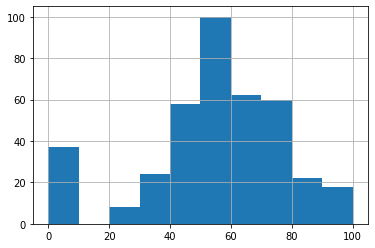

In [5]:
df=df.dropna(axis=0, subset=['score'])
print('Распределение значений score: \n', df.score.value_counts())
df.score.hist()

В 37 наблюдениях целевая переменная имеет значение 0. Предполагаем, что такой балл мог быть получен скорее всего за неявку на экзамен (например, по состоянию здоровья) или аннулирование результатов по разного рода причинам. Удалять такие строки будет не совсем корректно, потому что неявка тоже может указывать на группу риска. Можно создать биномиальный столбец score_ind со значениями 0, если score == 0, и 1 в остальных случаях 

In [6]:
df['score_ind'] = df.apply(lambda x: 0 if x.score == 0 else 1, axis=1)

# Признак school:

In [7]:
df.school.value_counts()

GP    344
MS     45
Name: school, dtype: int64

В датасете представлены данные по учащимся двух школ: GP и MS. Причем 88% учеников из датасета учатся в школе GP. Данный признак в дальнейшем можно будем перевести в dummy-переменные

In [8]:
#df2 = pd.get_dummies(df,columns=['school'])
#f2 = df2[['school_GP','school_MS'] + df2.columns[:-2].tolist()]
#df2.head(10)

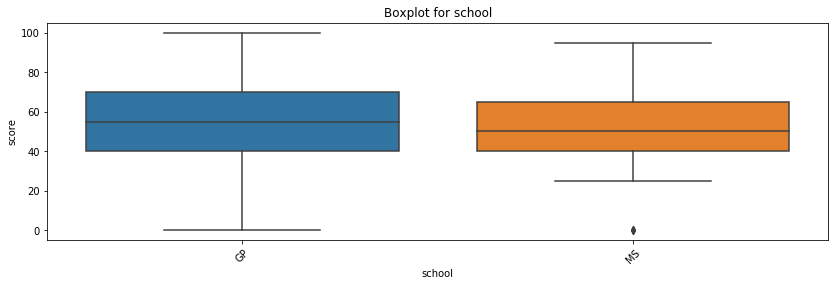

In [9]:
get_boxplot('school')

Видим, что ученики школы GP имеют больший разброс, но и количество их в датасете существенно больше. Если анализировать только квартили, то в целом можно сделать предварительный вывод о значимости школы в результатах экзамена.

# Признаки sex и age:

In [10]:
df.sex.value_counts()

F    204
M    185
Name: sex, dtype: int64

Поскольку значений действительно только 2 и пропусков нет. Пока оставим как есть, в дальнейшем можно будет аналогично названию школы перевести их в dummy-переменные

In [11]:
#df3 = pd.get_dummies(df2,columns=['sex'])
#df3 = df3[df3.columns[:2].tolist() + df3.columns[-2:].tolist() + df3.columns[2:-2].tolist()]
#df3.head(10)

Распределение значений возраста:
 16    103
17     98
15     82
18     80
19     21
20      3
22      1
21      1
Name: age, dtype: int64


count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

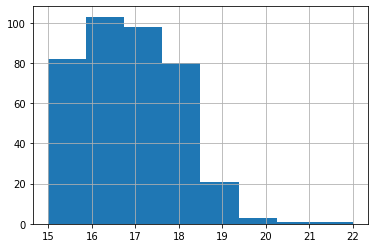

In [12]:
print('Распределение значений возраста:\n', df.age.value_counts())
df.age.hist(bins=8)
df.age.describe()

Действительно значения возраста строго в пределах от 15 до 22 лет, выбросов нет, большинство учеников до 18 лет включительно

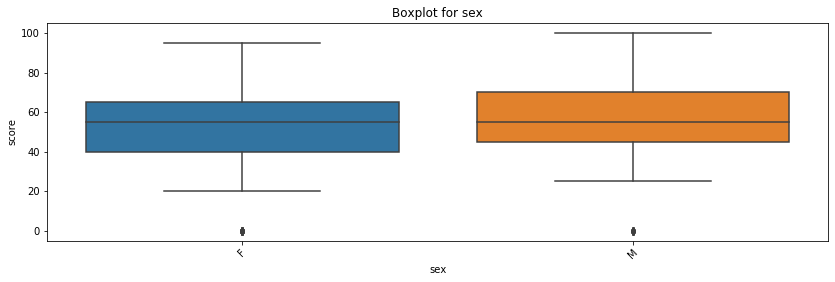

In [13]:
get_boxplot('sex')

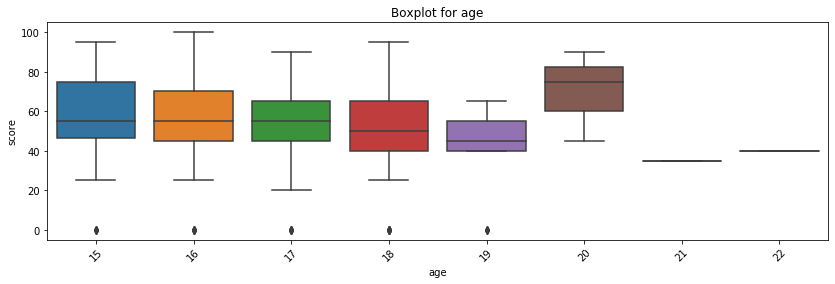

In [14]:
get_boxplot('age')

Пол имеет слабое значение для итоговых тестов: мальчики сдают экзамен по математике чуть лучше девочек, медианы у обеих групп совпадают.
Возраст также имеет небольшое значение. По графикам можно предположить, что для учащихся с 15 до 18 лет результативность экзамена снижается с каждым годом. Особенно хуже результаты показывает группа 18 лет. Попробуем проанализировать возраст как числовой признак:

In [15]:
df[['age','score','score_ind']].corr()

,age,score,score_ind
age,1.000000,-0.155726,-0.097603
score,-0.155726,1.000000,0.740253
score_ind,-0.097603,0.740253,1.000000


Как и по графику boxplot мы видим, что набранные на экзамене баллы немного уменьшаются с возрастом учащихся

# Признак address

Следующий признак <b>address</b>, в нем есть пропуски. Посмотрим, можно ли их заполнить исходя из школы и времени в пути до школы

In [16]:
print('Для школы GP:')
print('Распределение значений:\n', df[df.school == 'GP'].groupby(['address']).traveltime.value_counts())
print('\nПо среднему значению:\n', df[df.school == 'GP'].groupby(['address']).traveltime.mean())
print('\nДля школы MS:')
print('Распределение значений:\n', df[df.school == 'MS'].groupby(['address']).traveltime.value_counts())
print('\nПо среднему значению:\n', df[df.school == 'MS'].groupby(['address']).traveltime.mean())

Для школы GP:
Распределение значений:
 address  traveltime
R        1.0            29
         2.0            18
         3.0             5
         4.0             3
U        1.0           190
         2.0            54
         3.0             9
         4.0             3
Name: traveltime, dtype: int64

По среднему значению:
 address
R    1.672727
U    1.316406
Name: traveltime, dtype: float64

Для школы MS:
Распределение значений:
 address  traveltime
R        2.0           8
         3.0           7
         1.0           5
         4.0           1
U        2.0           9
         1.0           8
Name: traveltime, dtype: int64

По среднему значению:
 address
R    2.190476
U    1.529412
Name: traveltime, dtype: float64


Таким образом, видно, что для школы MS значения traveltime 3 и 4 есть только для address == "R", значение 1 чаще встречается для address == "U", значение 2 - примерно одинаковое как для "R", так и для "U". Так как пропусков немного, заполним в таком случае значение адреса рандомно.
Для школы GP: по средним значениям traveltime предположим, что если traveltime == 1, то address == "U", для остальных - address = "R". Если значение traveltime отсутствует, то пропуски в address заполним по наиболее чаще встречаемому значению:

In [17]:
print('Для школы GP наиболее часто встречающееся значение address: ',df[df.school == 'GP'].address.value_counts().index[0])
print('Для школы MS наиболее часто встречающееся значение address: ',df[df.school == 'MS'].address.value_counts().index[0])

Для школы GP наиболее часто встречающееся значение address:  U
Для школы MS наиболее часто встречающееся значение address:  R


In [18]:
import random
address_list = ['U','R']

In [19]:
df.address = df.apply(lambda x: ('U' if ((x.traveltime == 1) or (x.school == 'GP' and pd.isna(x.traveltime)))
                                    else (random.choice(address_list) if (x.school == 'MS' and x.traveltime == 2)
                                         else 'R')) 
                        if pd.isna(x.address) else x.address, axis=1)

Для подтверждения корректности сравним средние значения и убедимся, что все пропуски заполнены:

In [20]:
print('Среднее значение traveltime по типу адреса для школы GP:\n', df[df.school == 'GP'].groupby(['address']).traveltime.mean())
print('\nСреднее значение traveltime по типу адреса для школы MS:\n', df[df.school == 'MS'].groupby(['address']).traveltime.mean())
print('\nПустых значений address: ',pd.isna(df['address']).sum())

Среднее значение traveltime по типу адреса для школы GP:
 address
R    1.684211
U    1.307985
Name: traveltime, dtype: float64

Среднее значение traveltime по типу адреса для школы MS:
 address
R    2.173913
U    1.555556
Name: traveltime, dtype: float64

Пустых значений address:  0


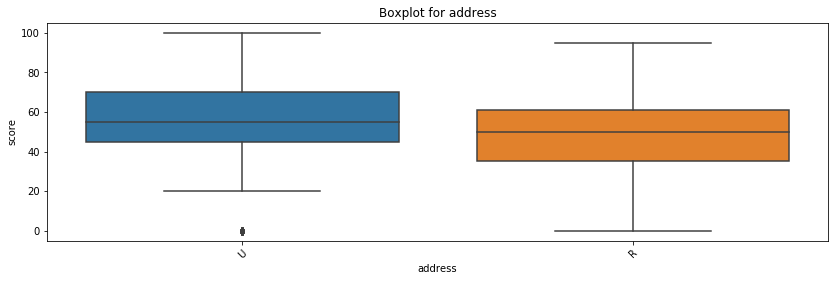

In [21]:
get_boxplot('address')

Учеников, живущих в городе, больше. Однако по графику видим, что значения квартилей сильно отличаются для разных типов адресов

# Признак famsize

Следующий признак <b>famsize</b>. Пропусков в нем больше. Попробуем найти взаимосвязь с признаками Pstatus и famrel:

In [22]:
df.famsize.value_counts()

GT3    255
LE3    107
Name: famsize, dtype: int64

In [23]:
df.groupby(['Pstatus']).famsize.value_counts()

Pstatus  famsize
A        GT3         20
         LE3         13
T        GT3        207
         LE3         81
Name: famsize, dtype: int64

Видно, что если родители ученика живут вместе, то размер семьи скорее всего будет более 3 человек. Не всё так однозначно с ситуацией, когда родители живует раздельно. Добавим распределение по показателю отношений в семье:

In [24]:
print('Для учеников, у которых родители живут раздельно\n', df[df.Pstatus=='A'].famrel.value_counts())
print('\n',df[df.Pstatus=='A'].groupby(['famsize']).famrel.value_counts())

Для учеников, у которых родители живут раздельно
 4.0    12
5.0    11
3.0     5
2.0     3
1.0     1
Name: famrel, dtype: int64

 famsize  famrel
GT3      4.0       6
         5.0       5
         3.0       4
         2.0       2
         1.0       1
LE3      5.0       6
         4.0       4
         2.0       1
         3.0       1
Name: famrel, dtype: int64


В целом по всем наблюдениям с родителями, живущими раздельно, чаще всего отношения внутри семьи оцениваются как хорошие и очень хорошие. Но при этом в маленьких семьях крайне мало отрицательных оценок famrel. Таким образом, можно предположить, что если оценка famrel > 3, тогда семья менее 3 человек. В остальных случаях предположим, что семья более 3 человек. В случае пропуска значения famrel или Pstatus подставим наиболее часто встречающееся значение GT3. После этого убедимся, что пропусков нет

In [25]:
df['famsize'] = df.apply(lambda x: ('GT3' if (x.Pstatus == 'T' or (x.Pstatus == 'A' and x.famrel <4)) 
                                    else 'LE3') if pd.isna(x.famsize) else x.famsize, axis=1)
print('Распределение значений famsize:\n', df.famsize.value_counts(),'\n')
print('Количество пропусков в столбце famsize: ', pd.isna(df['famsize']).sum())

Распределение значений famsize:
 GT3    275
LE3    114
Name: famsize, dtype: int64 

Количество пропусков в столбце famsize:  0


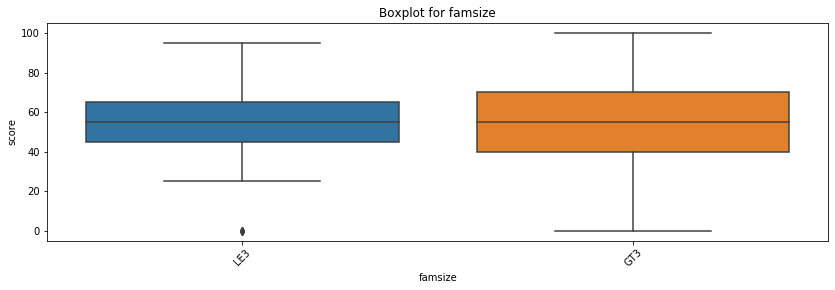

In [26]:
get_boxplot('famsize')

Больших семей по количеству больше более чем в 2 раза. Разброс значений score в них так же шире. При этом медианы для обеих групп на одном уровне

# Признак Pstatus

Посмотрим распределение и количество пропусков

In [27]:
print('Распределение значений Pstatus: \n', df.Pstatus.value_counts())
print('Количество пропусков: ', pd.isna(df['Pstatus']).sum())

Распределение значений Pstatus: 
 T    308
A     36
Name: Pstatus, dtype: int64
Количество пропусков:  45


Около 80% значений составляет "T", то есть семьи, где родители живут вместе. При этом пропусков более 11%. Причины пропусков нам неизвестны и заполнить их способами выше не представляется возможным, поэтому заполним их третьим значением 'N', которое будет означать, что информация неизвестна

In [28]:
df.Pstatus = df.Pstatus.fillna('N')

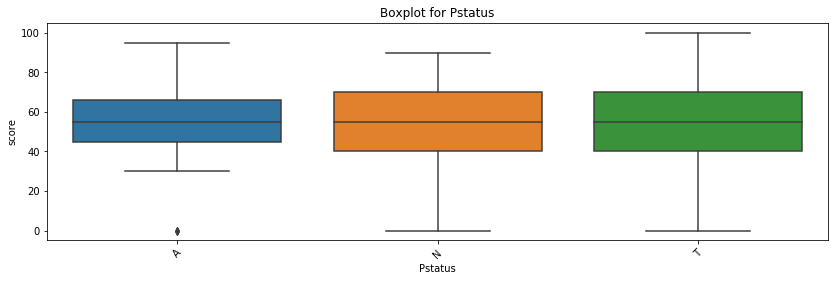

In [29]:
get_boxplot('Pstatus')

По графику нет возможности определить значимость статуса родителей на результаты экзамены, тем более, что признак плохо сбалансирован

# Признаки Medu, Fedu и Mjob, Fjob   

Распределение значений Medu:
 4.0    131
2.0    100
3.0     96
1.0     56
0.0      3
Name: Medu, dtype: int64 

Количество пропусков Medu:  3 



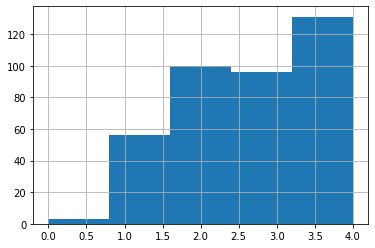

In [30]:
print('Распределение значений Medu:\n', df.Medu.value_counts(),'\n')
print('Количество пропусков Medu: ', pd.isna(df['Medu']).sum(),'\n')
df.Medu.hist(bins=5)

Распределение значений Fedu:
 2.0     105
3.0      94
4.0      88
1.0      75
0.0       2
40.0      1
Name: Fedu, dtype: int64 

Количество пропусков Fedu:  24 



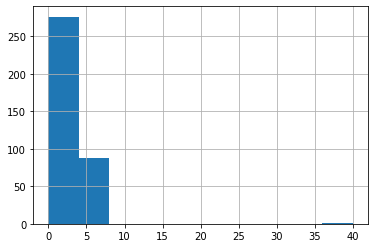

In [31]:
print('Распределение значений Fedu:\n', df.Fedu.value_counts(),'\n')
print('Количество пропусков Fedu: ', pd.isna(df['Fedu']).sum(),'\n')
df.Fedu.hist()

В столбце Medu пропусков всего 3. Поскольку это категориальный признак, мы не можем заполнить его статистическими характеристиками типа медианы или среднего. Пока добавим для пропусков новое значение "-1", это будет означать, что информация неизвестна.
В столбце Fedu пропусков значительно больше, при этом есть выброс - 40. Поскольку в изначальном описании датасета указано, что значения могут быть только целочисленными от 0 до 4 включительно, можно предположить, что 40 на самом деле означает 4.
Напишем функцию, которая будет преобразовывать 10, 20, 30 и 40 в 1, 2, 3 и 4 соответственно:

Распределение значений Fedu:
 2.0    105
3.0     94
4.0     89
1.0     75
0.0      2
Name: Fedu, dtype: int64 

Количество пропусков Fedu:  24 



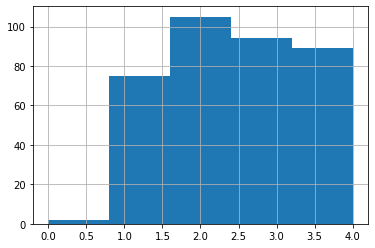

In [32]:
df['Fedu'] = df.apply(lambda x: x.Fedu/10 if (10 <= x.Fedu <= 40 and x.Fedu%10 == 0) else x.Fedu, axis=1)
print('Распределение значений Fedu:\n', df.Fedu.value_counts(),'\n')
print('Количество пропусков Fedu: ', pd.isna(df['Fedu']).sum(),'\n')
df.Fedu.hist(bins=5)

Проверим гипотезу, что уровень образования одного родителя может коррелировать с уровнем образования другого родителя (хотя считать корреляцию категориальных признаков не совсем корректно):

In [33]:
df[['Medu','Fedu']].corr()

,Medu,Fedu
Medu,1.000000,0.621981
Fedu,0.621981,1.000000


Коэффициент корреляции 0.62 не может дать нам однозначного ответа, хотя в большинстве случаев образование одного родителя связано с образованием другого родителя. То есть в большинстве семей родители примерно одинакового уровня образования. 
Попробуем объединить эти два признака в новый Par_edu - Если guardian == mother, то значение Medu, если father, то значение Fedu, в остальных случаях - максимальное значение из Fedu и Medu

In [34]:
df['Par_edu'] = df.apply(lambda x: x.Medu if x.guardian == 'mother' else (x.Fedu if x.guardian == 'father' 
                                                                          else x[['Medu','Fedu']].max()), axis=1)
df.Par_edu = df.Par_edu.fillna(df[['Medu','Fedu']].max(axis=1))


In [35]:
pd.isna(df.Par_edu).sum()

0

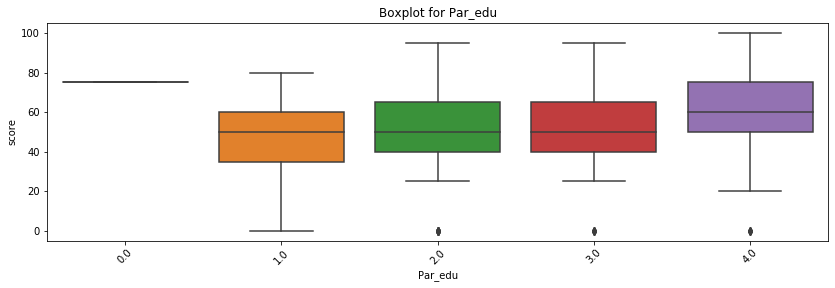

In [36]:
get_boxplot('Par_edu')

Видим явную связь между образованием родителей и результатами экзаменов. Это имеет разумное объяснение: дети как правило тянутся к уровню родителей

Распределение значений Mjob:
 other       127
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64 

Количество пропусков Mjob:  19 



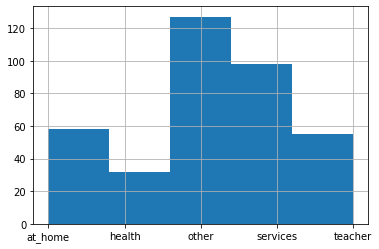

In [37]:
print('Распределение значений Mjob:\n', df.Mjob.value_counts(),'\n')
print('Количество пропусков Mjob: ', pd.isna(df['Mjob']).sum(),'\n')
df.Mjob.hist(bins=5)

Распределение значений Fjob:
 other       194
services     99
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64 

Количество пропусков Fjob:  36 



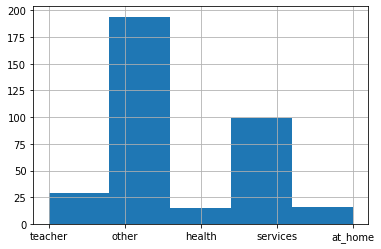

In [38]:
print('Распределение значений Fjob:\n', df.Fjob.value_counts(),'\n')
print('Количество пропусков Fjob: ', pd.isna(df['Fjob']).sum(),'\n')
df.Fjob.hist(bins=5)

Преобразуем значения столбцов Mjob и Fjob в числовые, но при этом остающиеся категориальными, а затем создадим новый столбец Par_job, описывающий статус обоих родителей. При этом считать будем только "работает"/"не работает"

In [39]:
job_list = ['other', 'services', 'health', 'teacher']
df['Mjob_int'] = df.apply(lambda x: 0 if x.Mjob == 'at_home' else (1 if x.Mjob in job_list else -2), axis=1)

In [40]:
df['Fjob_int'] = df.apply(lambda x: 0 if x.Fjob == 'at_home' else (1 if x.Fjob in job_list else -2), axis=1)

In [41]:
df['Par_job'] = df['Mjob_int'] + df['Fjob_int']

In [42]:
df.Par_job.value_counts()

 2    273
 1     57
-1     46
-2      7
 0      5
-4      1
Name: Par_job, dtype: int64

Таким образом, мы получили столбец категориального признака Par_job, который принимает следующие значения:
2 - оба родителя работают
1 - один из родителей работает, второй - не работает
0 - оба родителя не работают
-1 - один родитель работает, про второго неизвестно
-2 - один родитель не работает, про второго неизвестно
-4 - неизвестен рабочий статус обоих родителей

In [43]:
df = df.drop(['Mjob_int', 'Fjob_int'], 1)

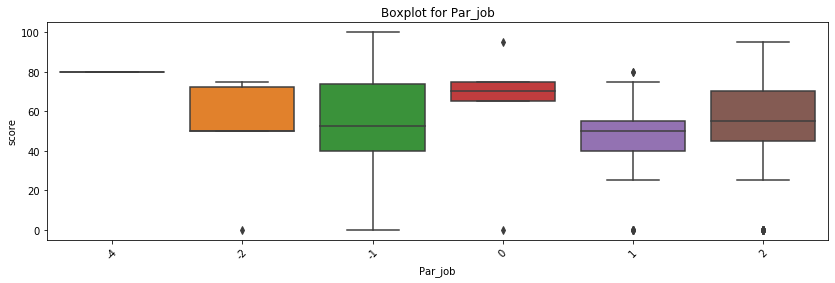

In [44]:
get_boxplot('Par_job')

Группы, в которых хотя бы один родитель работает (2, 1 и -1), самые многочисленные и результаты в них существенно отличаются

# Признак reason:

In [45]:
df.reason.value_counts()

course        135
reputation    102
home          101
other          34
Name: reason, dtype: int64

Пропусков 17, в основном для многих указана причина выбора школы. Заполним пропуски значением 'unknown'

In [46]:
df.reason = df.reason.fillna('unknown')
df.reason.value_counts()

course        135
reputation    102
home          101
other          34
unknown        17
Name: reason, dtype: int64

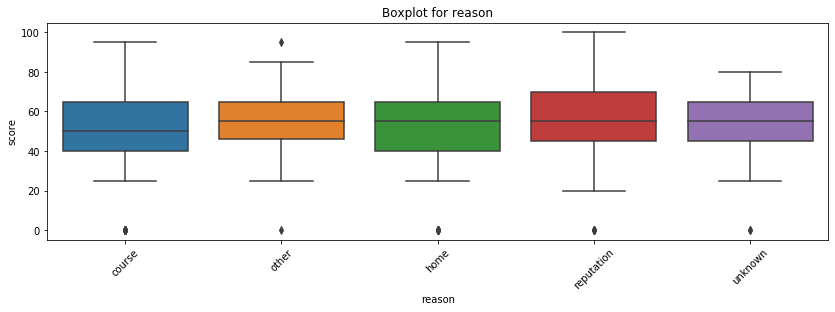

In [47]:
get_boxplot('reason')

По графику нет возможности предположить, что признак reason является значимым


# Признак guardian:

In [48]:
print('Распределение значений guardian:\n', df.guardian.value_counts(),'\n')
print('Количество пропусков guardian: ', pd.isna(df['guardian']).sum(),'\n')

Распределение значений guardian:
 mother    248
father     86
other      24
Name: guardian, dtype: int64 

Количество пропусков guardian:  31 



Поскольку пропусков много и эти данные могут иметь значимость, заполним отсутсвующие значения по аналогии с reason

In [49]:
df.guardian = df.guardian.fillna('unknown')

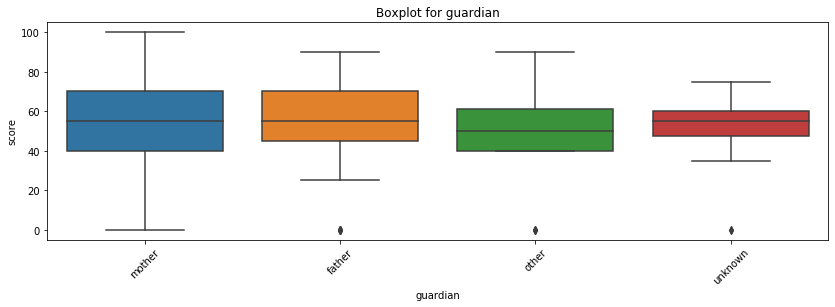

In [50]:
get_boxplot('guardian')

Медиана для значения other чуть ниже остальных. Значение mother самое многочисленное, поэтому и разброс больше

# Признаки traveltime, freetime, studytime, studytime granular

Временные признаки traveltime, studytime, freetime:
Они в целом похожи между собой, имеют разброс значений от 1 до 4 или от 1 до 5. При этом согласно здравому смыслу, чем больше значения traveltime и studytime, тем меньше должно быть свободного времени freetime. 
На данном этапе пока просто заменим пропуски значением 0

In [51]:
cols = ['traveltime','studytime','freetime']
df.traveltime = df.traveltime.fillna(0)
df.studytime = df.studytime.fillna(0)
df.freetime = df.freetime.fillna(0)
for col in cols:
    print('Распределение значений для ' + col,'\n',df[col].value_counts(), '\n')

Распределение значений для traveltime 
 1.0    239
2.0     94
0.0     28
3.0     21
4.0      7
Name: traveltime, dtype: int64 

Распределение значений для studytime 
 2.0    189
1.0    103
3.0     63
4.0     27
0.0      7
Name: studytime, dtype: int64 

Распределение значений для freetime 
 3.0    152
4.0    110
2.0     63
5.0     37
1.0     18
0.0      9
Name: freetime, dtype: int64 



У большинства учащихся время в пути до школы занимает не более 30 минут, на учебу помимо школы тратится не более 5 часов, при это свободного времени - не мало

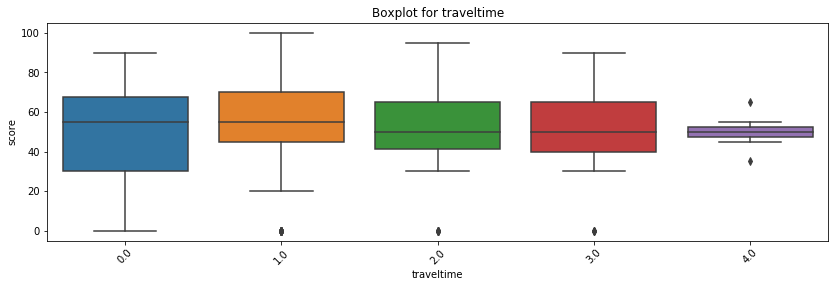

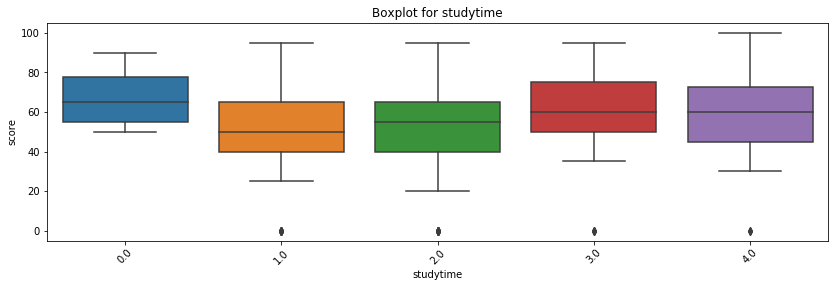

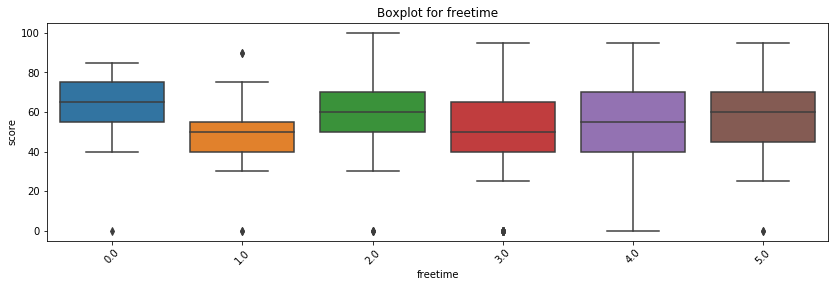

In [52]:
for col in cols:
    get_boxplot(col)

Больше всего в глаза бросается график studytime - чем больше ученик занимается учебой вне школы, тем выше у него шансы получить высокий балл на экзамене.
Интересная ситуация с freetime. Те, кто указал, что свободного времени очень мало, на деле получают меньшие баллы чем те, у кого свободного времени много и очень много. 

В датасете есть признак, описание которому отсутсвует - <b>studytime, granular</b>

In [53]:
st = df[['studytime','studytime, granular']]
print('Распределение значений по studytime')
display(st['studytime'].value_counts())
print('Распределение значений по studytime, granular')
display(st['studytime, granular'].value_counts())

Распределение значений по studytime


2.0    189
1.0    103
3.0     63
4.0     27
0.0      7
Name: studytime, dtype: int64

Распределение значений по studytime, granular


-6.0     189
-3.0     103
-9.0      63
-12.0     27
Name: studytime, granular, dtype: int64

In [54]:
st['div'] = st['studytime, granular'] / st['studytime']
print(st['div'].value_counts())
st.corr()

-3.0    382
Name: div, dtype: int64


C:\Users\nobrr\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,studytime,"studytime, granular",div
studytime,1.0,-1.0,NaN
"studytime, granular",-1.0,1.0,NaN
div,NaN,NaN,NaN


Похоже, что все значения <b>studytime, granular</b> отличаются от <b>studytime</b> ровно в (-3) раза. При такой линейной зависимости столбцов модель обучать нельзя, поскольку матрица корреляций вырожденна. Тем  более непонятен физический смысл столбца <b>studytime, granular</b>. Считаю верным его удалить

# Признак failures:

Распределение значений failures:
 0.0    290
1.0     48
2.0     15
3.0     14
Name: failures, dtype: int64 

Количество пропусков failures:  22 



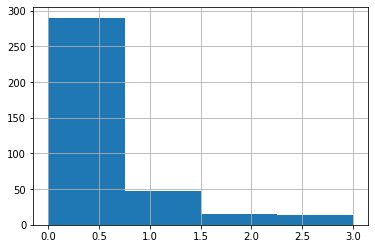

In [55]:
print('Распределение значений failures:\n', df.failures.value_counts(),'\n')
print('Количество пропусков failures: ', pd.isna(df['failures']).sum(),'\n')
df.failures.hist(bins=4)

Чаще всего данный признак принимает значение 0, при этом согласно исходному описанию, значение 0 присваивается, если количество внеучебных неудач лежит вне диапазона [1;3], то есть значение 0 может присваиваться как ученикам, у которых не было внеучебных неудач, так и что их было больше 3. При этом "обнуление" пропусков будет некорректным, лучше задать им какое-то иное значение, например -1.

In [56]:
df.failures = df.failures.fillna(-1)

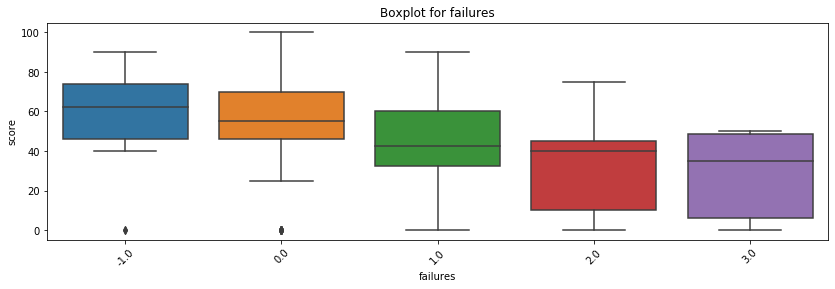

In [57]:
get_boxplot('failures')

По графику можно предположить связь между признаком failures и результатами экзамена

# Признаки schoolsup и famsup

Далее рассмотрим признаки образовательной поддержки schoolsup и famsup

Распределение значений schoolsup:
 no     331
yes     49
Name: schoolsup, dtype: int64 

Количество пропусков schoolsup:  9 



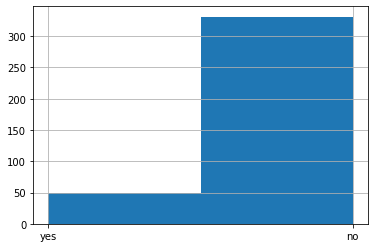

In [58]:
print('Распределение значений schoolsup:\n', df.schoolsup.value_counts(),'\n')
print('Количество пропусков schoolsup: ', pd.isna(df['schoolsup']).sum(),'\n')
df.schoolsup.hist(bins=2)

Распределение значений famsup:
 yes    216
no     135
Name: famsup, dtype: int64 

Количество пропусков famsup:  38 



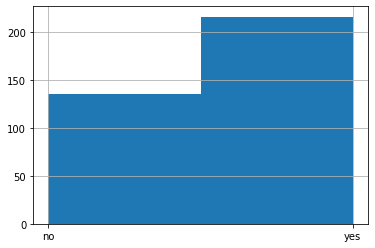

In [59]:
print('Распределение значений famsup:\n', df.famsup.value_counts(),'\n')
print('Количество пропусков famsup: ', pd.isna(df['famsup']).sum(),'\n')
df.famsup.hist(bins=2)

Подобные биномиальные признаки удобно переносить в числовой формат 0 и 1, пропуски опять же можно заменить на -1

In [60]:
df['schoolsup_int'] = df.apply(lambda x: 0 if x.schoolsup == 'no' else (1 if x.schoolsup == 'yes' else -1), axis=1)
df['famsup_int'] = df.apply(lambda x: 0 if x.famsup == 'no' else (1 if x.famsup == 'yes' else -1), axis=1)

Создадим столбец <b>support</b>, который показывал бы наличие какой-либо поддержки и -1 в случае неизвестных данных

In [61]:
df['support'] =df[['schoolsup_int','famsup_int']].max(axis=1)
df['support'].value_counts()

1    234
0    155
Name: support, dtype: int64

Таким образом мы избавились от пропусков, поскольку нет строк, где были бы неизвестны сразу оба признака

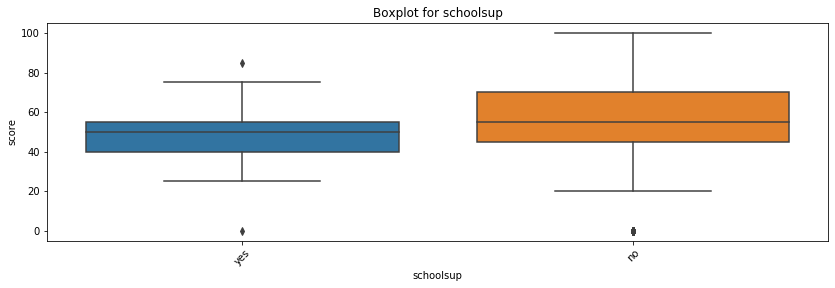

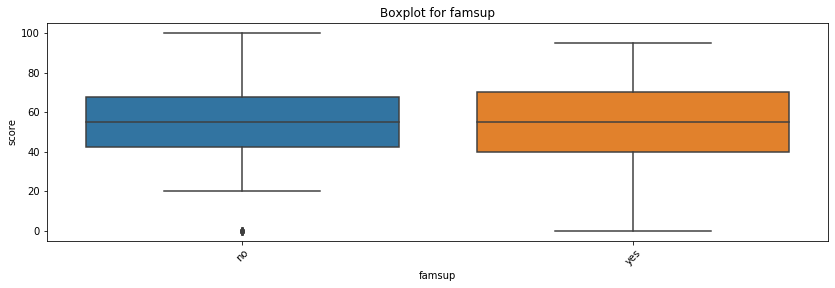

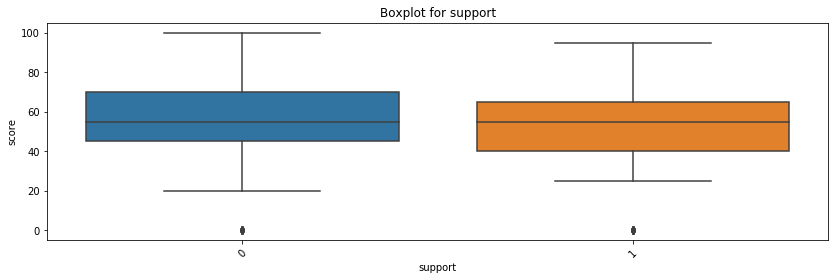

In [62]:
for col in ['schoolsup','famsup', 'support']:
    get_boxplot(col)

По графикам можно предположить, что ученики с образовательной поддержкой в целом хуже сдают экзамен по математике. Возможно, доп. поддержкой пользуются ученики с невысокой успеваемостью.

# Признаки paid, activities, nursery, higher, internet, romantic:

Все эти признаки биномиальные, для удобства можно перевести их в бинарный формат, но пропуски заполнить третьим значением, например -1

In [63]:
print('Распределение значений paid:\n', df.paid.value_counts(),'\n')
print('Количество пропусков paid: ', pd.isna(df['paid']).sum(),'\n')


Распределение значений paid:
 no     197
yes    153
Name: paid, dtype: int64 

Количество пропусков paid:  39 



In [64]:
print('Распределение значений activities:\n', df.activities.value_counts(),'\n')
print('Количество пропусков activities: ', pd.isna(df['activities']).sum(),'\n')

Распределение значений activities:
 yes    192
no     183
Name: activities, dtype: int64 

Количество пропусков activities:  14 



In [65]:
print('Распределение значений nursery:\n', df.nursery.value_counts(),'\n')
print('Количество пропусков nursery: ', pd.isna(df['nursery']).sum(),'\n')

Распределение значений nursery:
 yes    297
no      77
Name: nursery, dtype: int64 

Количество пропусков nursery:  15 



In [66]:
print('Распределение значений higher:\n', df.higher.value_counts(),'\n')
print('Количество пропусков higher: ', pd.isna(df['higher']).sum(),'\n')

Распределение значений higher:
 yes    350
no      19
Name: higher, dtype: int64 

Количество пропусков higher:  20 



In [67]:
print('Распределение значений internet:\n', df.internet.value_counts(),'\n')
print('Количество пропусков internet: ', pd.isna(df['internet']).sum(),'\n')

Распределение значений internet:
 yes    300
no      55
Name: internet, dtype: int64 

Количество пропусков internet:  34 



In [68]:
print('Распределение значений romantic:\n', df.romantic.value_counts(),'\n')
print('Количество пропусков romantic: ', pd.isna(df['romantic']).sum(),'\n')

Распределение значений romantic:
 no     235
yes    123
Name: romantic, dtype: int64 

Количество пропусков romantic:  31 



У признаков nursery, higher, internet слишком несбалансированное распределение значений между yes и no. То есть подавляющее большинство учащихся ходили в детский сад, хотят получить высшее образование и имеют дома интернет.

In [69]:
df['paid_int'] = df.apply(lambda x: 0 if x.paid == 'no' else (1 if x.paid == 'yes' else -1), axis=1)
df['activities_int'] = df.apply(lambda x: 0 if x.activities == 'no' else (1 if x.activities == 'yes' else -1), axis=1)
df['nursery_int'] = df.apply(lambda x: 0 if x.nursery == 'no' else (1 if x.nursery == 'yes' else -1), axis=1)
df['higher_int'] = df.apply(lambda x: 0 if x.higher == 'no' else (1 if x.higher == 'yes' else -1), axis=1)
df['internet_int'] = df.apply(lambda x: 0 if x.internet == 'no' else (1 if x.internet == 'yes' else -1), axis=1)
df['romantic_int'] = df.apply(lambda x: 0 if x.romantic == 'no' else (1 if x.romantic == 'yes' else -1), axis=1)

In [70]:
df['paid'] = df.paid.fillna('unknown')
df['activities'] = df.activities.fillna('unknown')
df['nursery'] = df.nursery.fillna('unknown')
df['higher'] = df.higher.fillna('unknown')
df['internet'] = df.internet.fillna('unknown')
df['romantic'] = df.romantic.fillna('unknown')

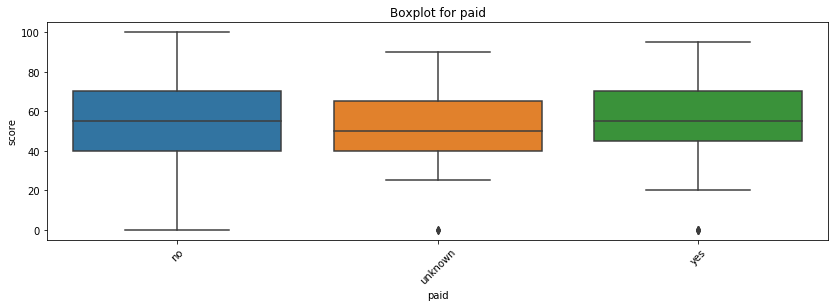

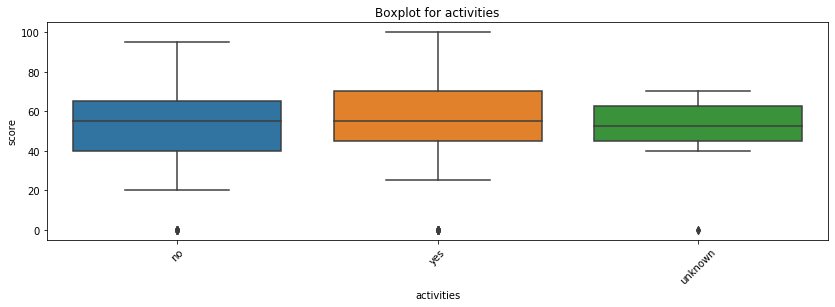

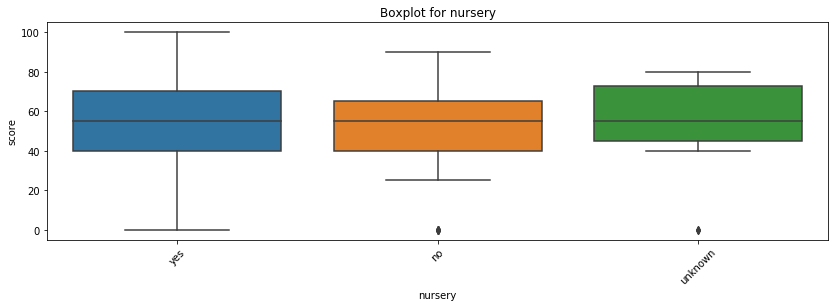

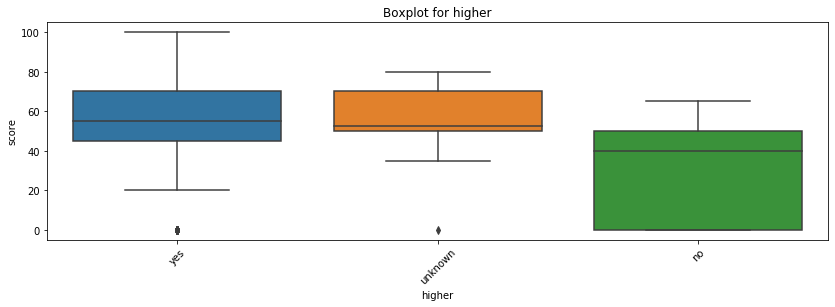

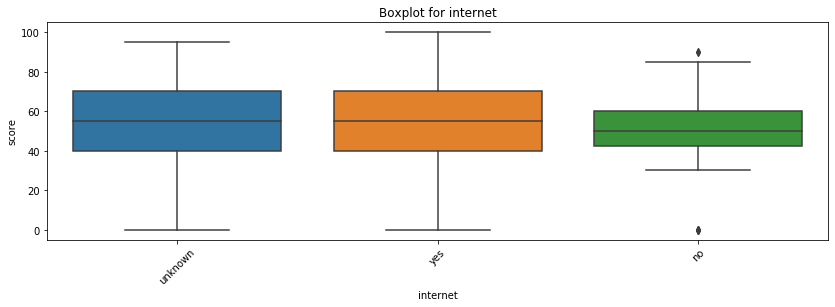

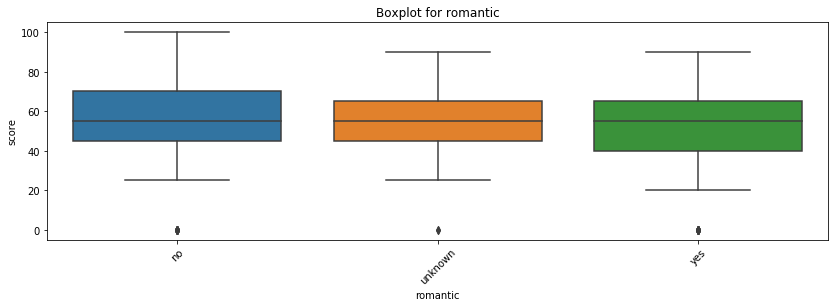

In [71]:
for col in ['paid','activities','nursery','higher','internet','romantic']:
    get_boxplot(col)

В целом все исследованные признаки имеют статистическую значимость для score в той или иной мере. Особо выделяются признаки nursery,higher,internet, которые упоминались выше из-за их несбалансированности. При этом следуя здравому смыслу эти признаки действительно могут влиять на итоговый балл. Также видим, что учащиеся, посещающие дополнительные внеучебные занятия (activities) имеют выше значения минимума, максимума, верхней и нижней квартили, но медиана примерно совпадает со значением no.
Похожая картина с признаком romantic. У учеников не состоящих в романтических отношениях (предположительно отдающих больше времени учебе) больше шансов получить высокий балл

# Признак famrel:

Распределение значений famrel:
  4.0    178
 5.0     97
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64 

Количество пропусков famrel:  27 



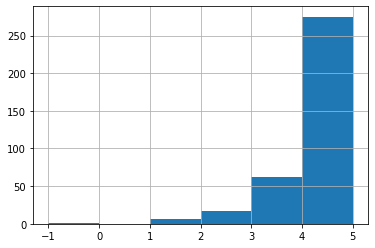

In [72]:
print('Распределение значений famrel:\n', df.famrel.value_counts(),'\n')
print('Количество пропусков famrel: ', pd.isna(df['famrel']).sum(),'\n')
df.famrel.hist(bins=6)

Видим, что есть значение -1, которое не соотносится с заданной в описании шкалой. Предполагаем, что -1 на самом деле 1

In [73]:
df['famrel'] = df.apply(lambda x: x.famrel * (-1) if x.famrel < 0 else x.famrel, axis=1)

Распределение значений famrel:
 4.0    178
5.0     97
3.0     62
2.0     17
1.0      8
Name: famrel, dtype: int64 



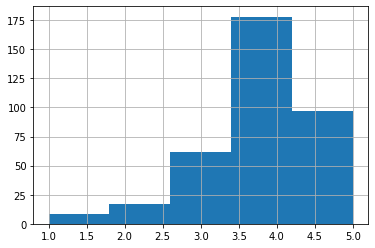

In [74]:
print('Распределение значений famrel:\n', df.famrel.value_counts(),'\n')
df.famrel.hist(bins=5)

Заполнить пропуски попробуем двумя способами, затем сравним полученные графики. 1 способ - через функцию random (famrel_rand), второй способ - учитывая пропорции текущих значений (famrel_prop)

4.0    185
5.0    106
3.0     65
2.0     20
1.0     13
Name: famrel_rand, dtype: int64

Количество пропусков famrel_rand:  0 



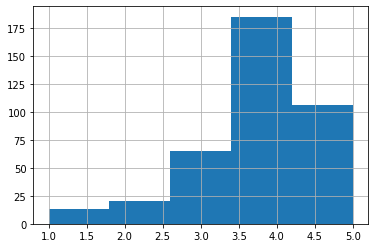

In [75]:
df['famrel_rand']= df.apply(lambda x: random.randint(1,5) if pd.isna(x.famrel) else x.famrel, axis=1)
display(df.famrel_rand.value_counts())
print('Количество пропусков famrel_rand: ', pd.isna(df['famrel_rand']).sum(),'\n')
df.famrel_rand.hist(bins=5)

4.0    188
5.0    108
3.0     68
2.0     17
1.0      8
Name: famrel_prop, dtype: int64

Количество пропусков famrel_prop:  0 



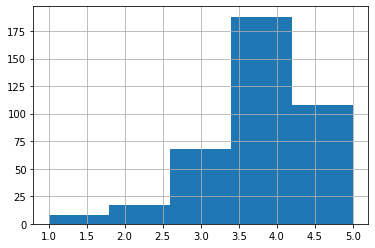

In [76]:
df['famrel_prop'] = df.famrel
df.famrel_prop = df.famrel_prop.interpolate(method='pad')
display(df.famrel_prop.value_counts())
print('Количество пропусков famrel_prop: ', pd.isna(df['famrel_prop']).sum(),'\n')
df.famrel_prop.hist(bins=5)

Заполнение по random сократило разрыв между значениями 1 и 2, в то время как заполнение по пропорции не добавило этих значений вообще. Но "на глаз" более похожим выглядит второй график. Поэтому остановимся на этом способе:

In [77]:
df = df.drop(['famrel_rand','famrel_prop'],1)

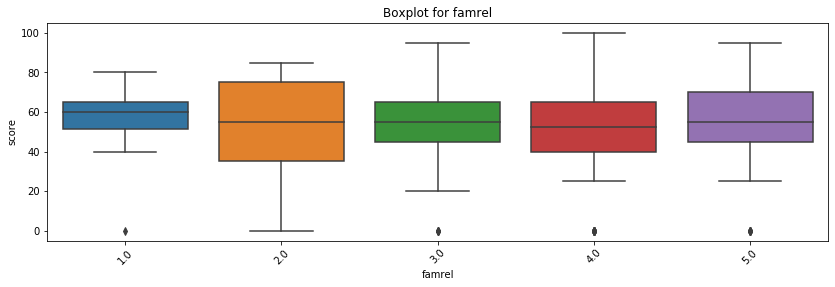

In [78]:
get_boxplot('famrel')

Видим, что разные значения признака famrel имеют разные статистические значения по score, таким образом признак можно считать значимым. Посмотрим, что будет, если мы обощим оценки: меньше 3 будет иметь значение 'bad', 3 - 'normal', больше 3 - 'good'

In [79]:
df['famrel_ind'] = df.apply(lambda x: 'bad' if x.famrel < 3 else ('normal' if x.famrel == 3 else 'good'), axis=1)
df.famrel_ind.value_counts()

good      302
normal     62
bad        25
Name: famrel_ind, dtype: int64

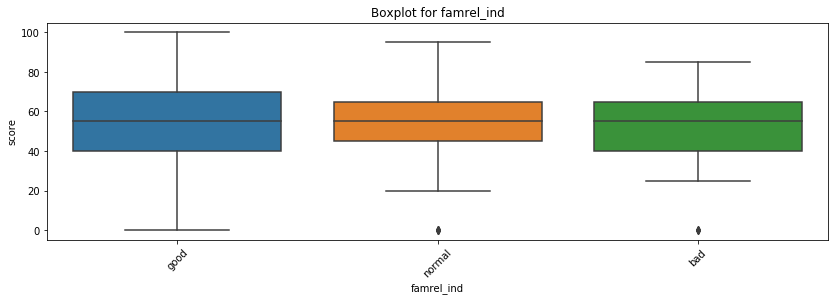

In [80]:
get_boxplot('famrel_ind')

 Видим, что при обобщении значения score для разных типов семейных отношений больше отличаются. Например, ученики с "плохими" отношениями в семье не набирали более 80 баллов на экзамене. Оставим этот признак вместо исходного famrel

# Признак goout:

Распределение значений goout:
 3.0    126
2.0    101
4.0     81
5.0     51
1.0     23
Name: goout, dtype: int64 

Количество пропусков goout:  7 



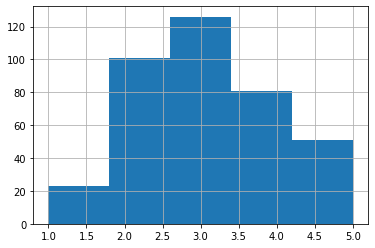

In [81]:
print('Распределение значений goout:\n', df.goout.value_counts(),'\n')
print('Количество пропусков goout: ', pd.isna(df['goout']).sum(),'\n')
df.goout.hist(bins=5)

Опять же видим нормальное распределение значений признака. Применим метод пропорций для заполнения пропусков, как для famrel:

3.0    126
2.0    105
4.0     81
5.0     54
1.0     23
Name: goout, dtype: int64

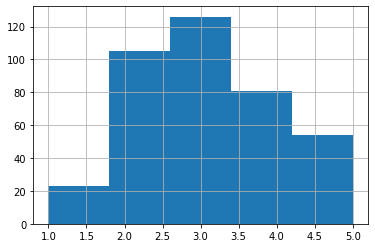

In [82]:
df.goout = df.goout.interpolate(method='pad')
display(df.goout.value_counts())
df.goout.hist(bins=5)

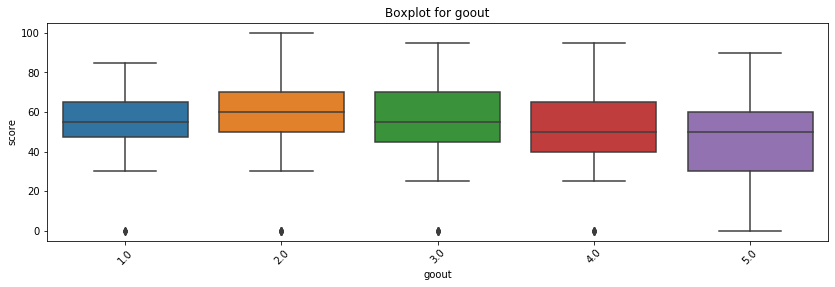

In [83]:
get_boxplot('goout')

На графике видно, что медианные значения score выше у тех, кто меньше проводит время с друзьями, значит этот признак значимый. Попробуем обобщить значения: если значение goout равняется 1 или 2, будем считать, что учащийся гуляет редко, если 3 - средне, если 4 или 5 - часто:

In [84]:
df['goout_ind'] = df.apply(lambda x: 'rarely' if x.goout < 3 else ('middle' if x.goout == 3 else 'often'), axis=1)
df.goout_ind.value_counts()

often     135
rarely    128
middle    126
Name: goout_ind, dtype: int64

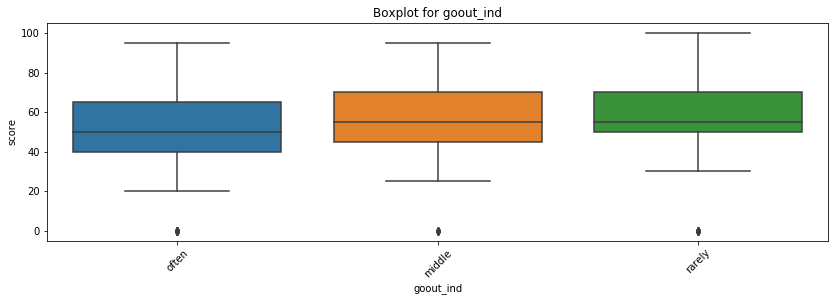

In [85]:
for col in ['goout_ind']:
    get_boxplot(col)

Видим, что для значения rarely практически все статистические величины выше: максимум, минимум, нижняя квартиль. У тех, кто гуляет с друзьями часто все эти показатели ниже. Можно оставить goout_ind вместо goout, чтобы в дальнейшем преобразовать его через dummy-переменные

# Признак health:

Распределение значений health:
 5.0    137
3.0     88
4.0     60
1.0     47
2.0     42
Name: health, dtype: int64 

Количество пропусков health:  15 



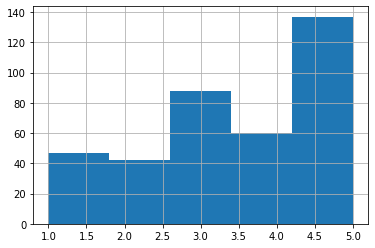

In [86]:
print('Распределение значений health:\n', df.health.value_counts(),'\n')
print('Количество пропусков health: ', pd.isna(df['health']).sum(),'\n')
df.health.hist(bins=5)

Попробуем заполнить пропусков аналогично предыдущим пунктам:

5.0    140
3.0     90
4.0     63
1.0     51
2.0     45
Name: health, dtype: int64

Количество пропусков health:  0 



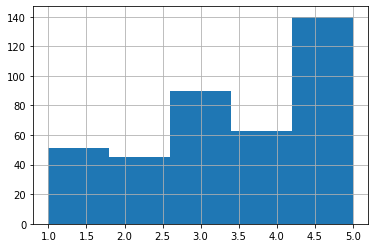

In [87]:
df['health'] = df.health.interpolate(method='pad')
display(df.health.value_counts())
print('Количество пропусков health: ', pd.isna(df['health']).sum(),'\n')
df.health.hist(bins=5)

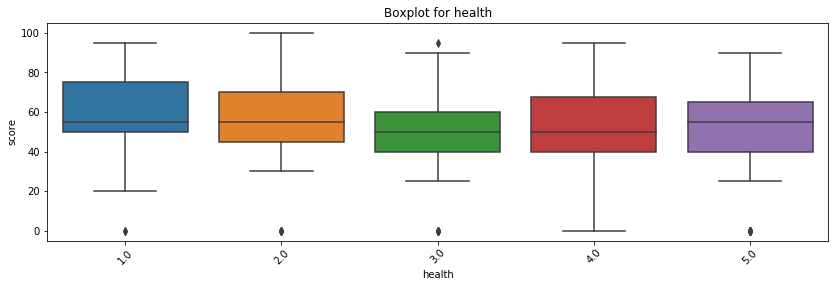

In [88]:
get_boxplot('health')

In [89]:
df['health_ind'] = df.apply(lambda x: 'bad' if x.health < 3 else ('normal' if x.health == 3 else 'good'), axis=1)
df.health_ind.value_counts()

good      203
bad        96
normal     90
Name: health_ind, dtype: int64

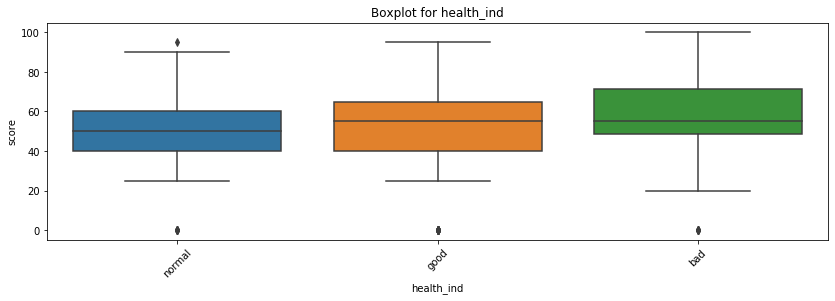

In [90]:
get_boxplot('health_ind')

Согласно графику получается, что ученики, жалующиеся на здоровье, в целом лучше сдают экзамены. Это может быть как причиной (высокие баллы получают чаще те, кто усидчиво занимается уроками, а низкая подвижность может отрицательно сказываться на здоровье), так и следствием (например, ученики с плохим здоровьем больше мотивированы на успех). Для дальнейшего анализа предлагаю оставить обощенный столбец для преобразования его через dummy-переменные

# Признак absences:

Распределение значений absences:
 0.0      110
2.0       60
4.0       52
6.0       30
8.0       20
10.0      17
12.0      12
14.0      12
3.0        7
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64 

Статистические параметры признака:
 count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64 

Количество пропусков absences:  11 



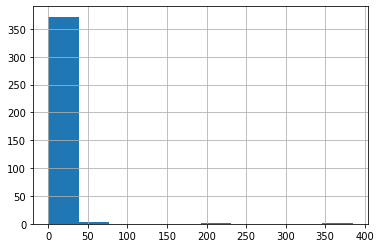

In [91]:
print('Распределение значений absences:\n', df.absences.value_counts(),'\n')
print('Статистические параметры признака:\n', df.absences.describe(),'\n')
print('Количество пропусков absences: ', pd.isna(df['absences']).sum(),'\n')
df.absences.hist()

На графике видно, что есть выбросы, причем в некоторых случаях количество пропущенных занятий измеряется сотнями. Попробуем от них избавиться

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].
4.0


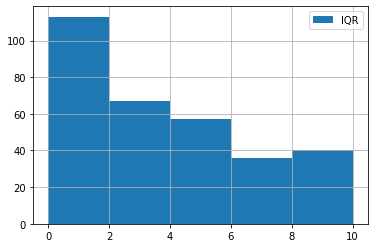

In [92]:
median = df.absences.median()
IQR = df.absences.quantile(0.75) - df.absences.quantile(0.25)
perc25 = df.absences.quantile(0.25)
perc75 = df.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
df.absences.loc[df.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 5, range = (0, 10), 
                                                                                             label = 'IQR')
plt.legend();
print(median)

25-й персентиль рассчитался как 0, нижняя граница выбросов -12, но количество пропусков меньше 0 быть не может, поэтому и нижнюю границу выбросов заменим на 0. Отфильтруем эти строки и посмотрим, сколько останется строк в датасете и какова будет корреляция с целевой переменной:

In [93]:
df = df.loc[df.absences.between(0, perc75 + 1.5*IQR)]
print('Осталось строк: ', len(df))
df[['absences','score']].corr()

Осталось строк:  361


,absences,score
absences,1.000000,0.081274
score,0.081274,1.000000


Видим, что 28 строк придется удалить. Коэффициент корреляции с переменной score составит чуть более 8%.

Интересно проверить гипотезу о связи состояния здоровья с пропущенными занятиями - возможно большинство учеников не приходят в школе по причине проблем со здоровьем:

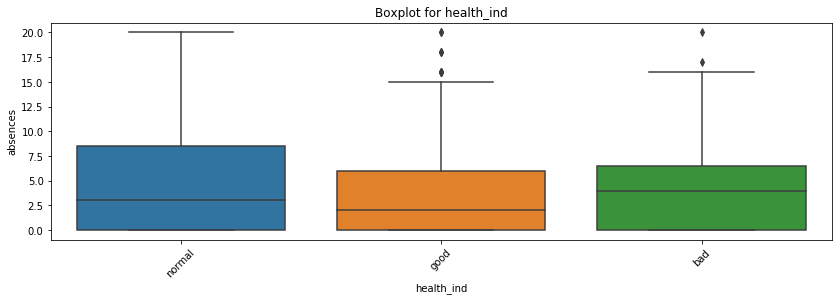

In [94]:
fig, ax = plt.subplots(figsize = (14, 4))
sns.boxplot(x='health_ind', y='absences', 
            data=df.loc[df.loc[:, 'health_ind'].isin(df.loc[:, 'health_ind'].value_counts().index[:])], ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot for health_ind')
plt.show()

Видим, что чаще всего пропускают занятия ученики из категории здоровья normal. Напомним, что это те, у кого исходный признак health имел значение 3, то есть хуже, чем хорошо, но и не совсем плохо. 

# Выбор значимых столбцов для модели

В этом блоке будем производить отбор признаков для построения модели. Для начала выведем все столбцы, которые мы получили в ходе преобразований:

In [95]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score', 'score_ind',
       'Par_edu', 'Par_job', 'schoolsup_int', 'famsup_int', 'support',
       'paid_int', 'activities_int', 'nursery_int', 'higher_int',
       'internet_int', 'romantic_int', 'famrel_ind', 'goout_ind',
       'health_ind'],
      dtype='object')

Оставим следующие: 
'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Par_edu', 'Par_job', 
'reason', 'guardian', 'traveltime', 'studytime','failures', 'support', 'paid_int',
'activities_int', 'nursery_int', 'higher_int', 'internet_int', 'romantic_int', 'famrel_ind', 
'freetime', 'goout_ind', 'health_ind', 'absences', 'score', 'score_ind',

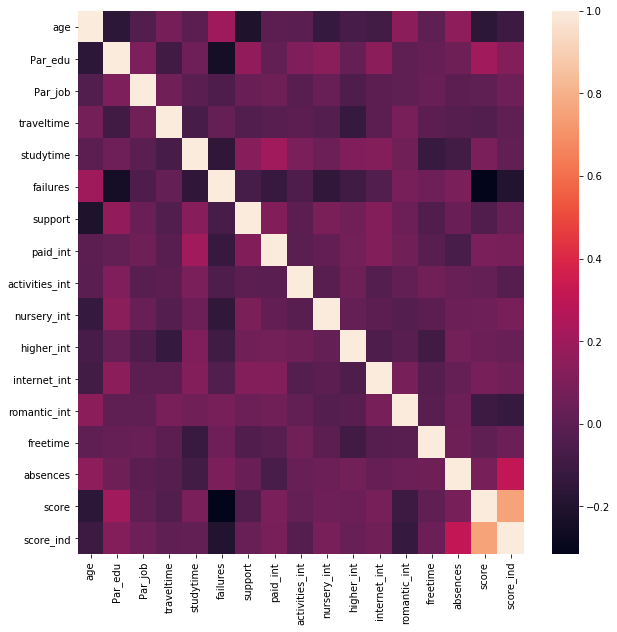

In [96]:
corr = df[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Par_edu', 'Par_job', 
'reason', 'guardian', 'traveltime', 'studytime','failures', 'support', 'paid_int',
'activities_int', 'nursery_int', 'higher_int', 'internet_int', 'romantic_int', 'famrel_ind', 
'freetime', 'goout_ind', 'health_ind', 'absences', 'score', 'score_ind']].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr)

In [97]:
corr

,age,Par_edu,Par_job,traveltime,studytime,failures,support,paid_int,activities_int,nursery_int,higher_int,internet_int,romantic_int,freetime,absences,score,score_ind
age,1.000000,-0.157126,-0.033922,0.076703,0.001344,0.202576,-0.209709,0.002248,-0.003993,-0.126496,-0.064662,-0.083201,0.147655,0.008142,0.155469,-0.159306,-0.103340
Par_edu,-0.157126,1.000000,0.104261,-0.087484,0.056798,-0.240059,0.164238,0.013476,0.109727,0.139844,0.027862,0.142078,0.010234,0.028269,0.050641,0.210676,0.122511
Par_job,-0.033922,0.104261,1.000000,0.059961,-0.007611,-0.046131,0.040997,0.049948,-0.018040,0.038004,-0.046426,-0.000938,0.008423,0.035790,-0.000657,0.009286,0.057661
traveltime,0.076703,-0.087484,0.059961,1.000000,-0.065405,0.023316,-0.037728,-0.012772,-0.002358,-0.024665,-0.126740,-0.000577,0.089240,0.000810,-0.019610,-0.033659,0.010273
studytime,0.001344,0.056798,-0.007611,-0.065405,1.000000,-0.147012,0.132950,0.211262,0.091712,0.046684,0.106080,0.125547,0.061561,-0.118001,-0.081188,0.091603,0.017735
failures,0.202576,-0.240059,-0.046131,0.023316,-0.147012,1.000000,-0.070020,-0.123590,-0.044357,-0.146056,-0.095110,-0.036053,0.084532,0.057698,0.092437,-0.316455,-0.197345
support,-0.209709,0.164238,0.040997,-0.037728,0.132950,-0.070020,1.000000,0.113211,0.000825,0.098551,0.066592,0.122211,0.043536,-0.042674,0.039308,-0.043731,0.034810
paid_int,0.002248,0.013476,0.049948,-0.012772,0.211262,-0.123590,0.113211,1.000000,-0.007626,0.018386,0.069448,0.117275,0.064336,-0.010027,-0.064137,0.094491,0.088047
activities_int,-0.003993,0.109727,-0.018040,-0.002358,0.091712,-0.044357,0.000825,-0.007626,1.000000,-0.018153,0.053386,-0.023739,0.014748,0.064844,0.035636,0.027483,-0.020173
nursery_int,-0.126496,0.139844,0.038004,-0.024665,0.046684,-0.146056,0.098551,0.018386,-0.018153,1.000000,0.026955,-0.000114,-0.023355,0.002262,0.046428,0.056952,0.085399


Проверим, есть ли статистическая разница в распределении оценок по категориальным признакам, с помощью теста Стьюдента

In [98]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [99]:
col_list = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Par_edu', 'Par_job', 
'reason', 'guardian', 'traveltime', 'studytime','failures', 'support', 'paid_int',
'activities_int', 'nursery_int', 'higher_int', 'internet_int', 'romantic_int', 'famrel_ind', 
'freetime', 'goout_ind', 'health_ind', 'absences']
for col in col_list:
    get_stat_dif(col)

C:\Users\nobrr\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\nobrr\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nobrr\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\nobrr\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\nobrr\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Из всех обработанных признаков статистически значимые по тесту Стьюдента колонки обнаружены не были. Отберем признаки, основываясь на графиках boxplot, приведенных при анализе каждой переменной. преобразуем категориальные признаки в dummy-переменные

In [100]:
df2 = pd.get_dummies(df,columns=['school','sex','address','famsize','famrel_ind','goout_ind','health_ind'])
df2 = df2.drop(['Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob','reason','guardian',
       'traveltime', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
       'studytime, granular', 'higher', 'internet',
       'romantic', 'famrel', 'goout', 'health',
       'schoolsup_int', 'famsup_int','nursery_int'], 1)
cols_new=['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U',
          'Par_edu', 'Par_job', 'famsize_GT3', 'famsize_LE3', 'famrel_ind_bad', 
          'famrel_ind_good', 'famrel_ind_normal', 'support', 'paid_int', 'activities_int', 
          'higher_int', 'internet_int', 'romantic_int', 'health_ind_bad', 'health_ind_good', 
          'health_ind_normal', 'goout_ind_middle', 'goout_ind_often', 'goout_ind_rarely', 
          'freetime', 'studytime', 'absences','failures','score', 'score_ind']
df2 = df2[cols_new]
df2.head(10)

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,Par_edu,Par_job,famsize_GT3,famsize_LE3,famrel_ind_bad,famrel_ind_good,famrel_ind_normal,support,paid_int,activities_int,higher_int,internet_int,romantic_int,health_ind_bad,health_ind_good,health_ind_normal,goout_ind_middle,goout_ind_often,goout_ind_rarely,freetime,studytime,absences,failures,score,score_ind
0,1,0,1,0,18,0,1,4.0,1,0,1,0,1,0,1,0,0,1,-1,0,0,0,1,0,1,0,3.0,2.0,6.0,0.0,30.0,1
1,1,0,1,0,17,0,1,1.0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,0,3.0,2.0,4.0,0.0,30.0,1
2,1,0,1,0,15,0,1,1.0,1,0,1,0,1,0,1,-1,0,1,1,-1,0,0,1,0,0,1,3.0,2.0,10.0,3.0,50.0,1
3,1,0,1,0,15,0,1,4.0,-1,1,0,0,0,1,1,1,1,1,1,1,0,1,0,0,0,1,2.0,3.0,2.0,0.0,75.0,1
4,1,0,1,0,16,0,1,3.0,2,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,1,3.0,2.0,4.0,0.0,50.0,1
5,1,0,0,1,16,0,1,4.0,2,0,1,0,1,0,1,1,1,1,1,0,0,1,0,0,0,1,4.0,2.0,10.0,0.0,75.0,1
6,1,0,0,1,16,0,1,2.0,2,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,4.0,2.0,0.0,0.0,55.0,1
7,1,0,1,0,17,0,1,4.0,2,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1.0,2.0,6.0,0.0,30.0,1
8,1,0,0,1,15,0,1,3.0,2,0,1,0,1,0,1,1,0,1,1,0,1,0,0,0,0,1,2.0,2.0,0.0,0.0,95.0,1
9,1,0,0,1,15,0,1,3.0,2,0,1,0,1,0,1,1,1,1,1,0,0,1,0,0,0,1,5.0,2.0,0.0,0.0,75.0,1


,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,Par_edu,Par_job,famsize_GT3,famsize_LE3,famrel_ind_bad,famrel_ind_good,famrel_ind_normal,support,paid_int,activities_int,higher_int,internet_int,romantic_int,health_ind_bad,health_ind_good,health_ind_normal,goout_ind_middle,goout_ind_often,goout_ind_rarely,freetime,studytime,absences,failures,score,score_ind
score,0.035723,-0.035723,-0.114883,0.114883,-0.159306,-0.115024,0.115024,0.210676,0.009286,-0.080734,0.080734,-0.015274,0.037281,-0.032273,-0.043731,0.094491,0.027483,0.048286,0.080582,-0.109951,0.082353,-0.021526,-0.057919,0.092650,-0.161977,0.070711,0.008865,0.091603,0.081274,-0.316455,1.000000,0.754867
score_ind,-0.008222,0.008222,-0.060183,0.060183,-0.103340,-0.037856,0.037856,0.122511,0.057661,-0.089234,0.089234,-0.026738,0.025086,-0.010611,0.034810,0.088047,-0.020173,0.035520,0.062081,-0.127435,0.014610,-0.019490,0.008243,0.074251,-0.053331,-0.020278,0.048308,0.017735,0.307899,-0.197345,0.754867,1.000000


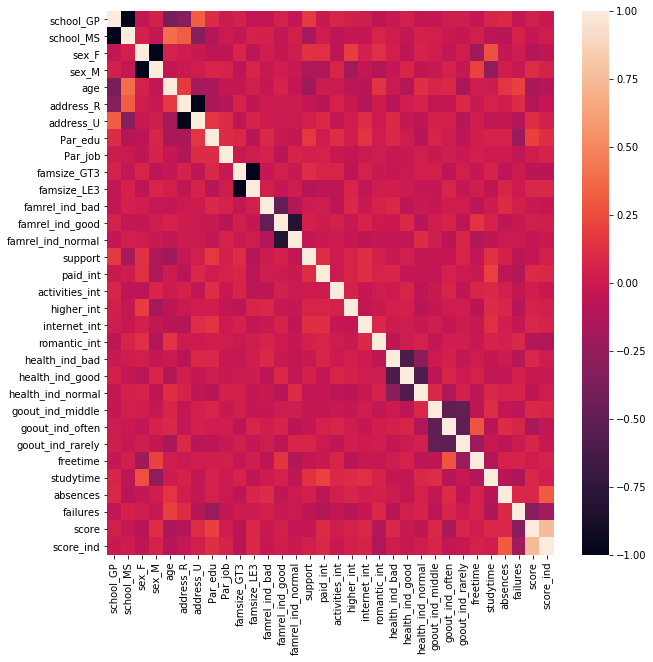

In [101]:
fig, ax = plt.subplots(figsize=(10,10))
display(df2.corr()[-2:])
sns.heatmap(df2.corr())

Удалим признаки, которые сильно скоррелированы между собой (по причине преобразования их в dummy):
оставим только одну школу GP, пол F, адрес U, размер семьи GT3, отношения в семье good, здоровье good, 
время с друзьями often:

In [102]:
df2 = df2.drop(['school_MS','sex_M','address_R','famsize_LE3','famrel_ind_bad','famrel_ind_normal',
               'health_ind_bad','health_ind_normal','goout_ind_middle','goout_ind_rarely'], 1)

,school_GP,sex_F,age,address_U,Par_edu,Par_job,famsize_GT3,famrel_ind_good,support,paid_int,activities_int,higher_int,internet_int,romantic_int,health_ind_good,goout_ind_often,freetime,studytime,absences,failures,score,score_ind
school_GP,1.000000,-0.044621,-0.384732,0.327484,0.102585,0.005179,0.049327,0.053571,0.176566,-0.013004,0.075012,0.032706,0.026383,-0.065696,0.045071,0.011746,-0.033131,0.075681,0.087886,-0.050833,0.035723,-0.008222
sex_F,-0.044621,1.000000,0.053862,-0.010221,-0.073206,-0.059163,0.075431,-0.024928,0.135648,0.125253,-0.072702,0.188809,0.039160,0.127080,-0.077153,-0.047446,-0.214751,0.271580,-0.025119,0.015844,-0.114883,-0.060183
age,-0.384732,0.053862,1.000000,-0.173291,-0.157126,-0.033922,-0.032765,0.055020,-0.209709,0.002248,-0.003993,-0.064662,-0.083201,0.147655,-0.101650,0.091208,0.008142,0.001344,0.155469,0.202576,-0.159306,-0.103340
address_U,0.327484,-0.010221,-0.173291,1.000000,0.155307,0.107281,-0.056858,-0.002602,0.031694,0.084893,-0.050404,0.014558,0.113526,-0.006862,-0.030533,0.045556,0.013401,-0.047527,-0.029621,-0.101922,0.115024,0.037856
Par_edu,0.102585,-0.073206,-0.157126,0.155307,1.000000,0.104261,0.086813,-0.013203,0.164238,0.013476,0.109727,0.027862,0.142078,0.010234,0.012058,0.013767,0.028269,0.056798,0.050641,-0.240059,0.210676,0.122511
Par_job,0.005179,-0.059163,-0.033922,0.107281,0.104261,1.000000,-0.009139,-0.080214,0.040997,0.049948,-0.018040,-0.046426,-0.000938,0.008423,-0.008372,0.022513,0.035790,-0.007611,-0.000657,-0.046131,0.009286,0.057661
famsize_GT3,0.049327,0.075431,-0.032765,-0.056858,0.086813,-0.009139,1.000000,0.033153,0.113838,0.077681,0.068513,-0.077463,0.048574,-0.010015,-0.003224,-0.071822,-0.028551,0.055395,-0.071965,0.002831,-0.080734,-0.089234
famrel_ind_good,0.053571,-0.024928,0.055020,-0.002602,-0.013203,-0.080214,0.033153,1.000000,0.040120,0.001077,0.044149,-0.019571,0.055030,-0.005676,0.088278,0.055369,0.147034,0.049438,-0.056282,-0.015359,0.037281,0.025086
support,0.176566,0.135648,-0.209709,0.031694,0.164238,0.040997,0.113838,0.040120,1.000000,0.113211,0.000825,0.066592,0.122211,0.043536,0.042440,-0.031320,-0.042674,0.132950,0.039308,-0.070020,-0.043731,0.034810
paid_int,-0.013004,0.125253,0.002248,0.084893,0.013476,0.049948,0.077681,0.001077,0.113211,1.000000,-0.007626,0.069448,0.117275,0.064336,-0.036180,0.051219,-0.010027,0.211262,-0.064137,-0.123590,0.094491,0.088047


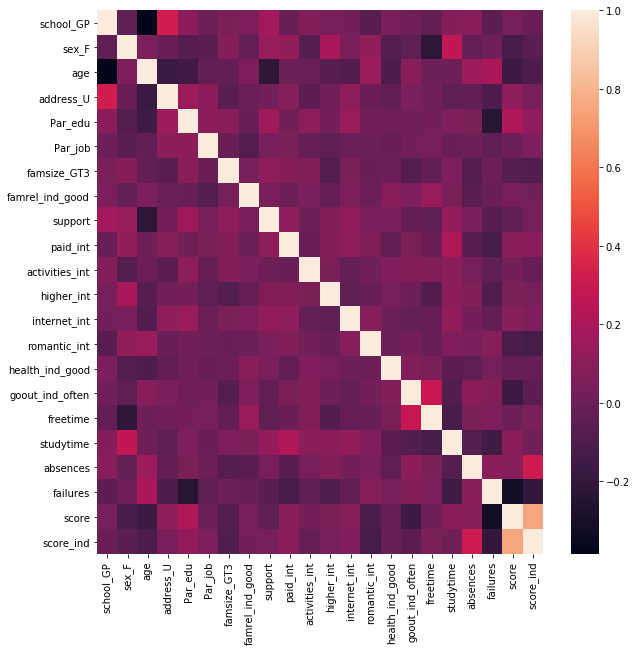

In [103]:
fig, ax = plt.subplots(figsize=(10,10))
display(df2.corr())
sns.heatmap(df2.corr())

Отобранные признаки будем использовать для построения модели в дальнейшем

In [105]:
df_for_model = df2

# Итоги

Таким образом были отобраны признаки, которые на мой взгляд могут быть использованы для модели машинного обучения, которая будет решать поставленную задачу оценки уровня риска учащихся по баллу на госэкзамене по математике.

Комментарий для ментора:
Поскольку времени на выполнение проекта было мало, не удалось хорошо проработать и изучить какие-то дополнительные материалы (не представленные в курсе). На мой взгляд, оценка значимости признаков выполнена в несколько эмпирическом ключе, имеет место быть индукция. К тому же сам датасет небольшой и данных явно мало, чтобы сделать максимально точные выводы. Однако считаю, что проделанная работа в целом корректна.